# Homework Assignment 2
Return this notebook (filled with your answers) by the deadline via mycourses. Also provide pdf printout of the notebook.

Note that the notebook that you submit needs to work. Reduction of points may be possible if it does not.

Name: **Xingji Chen** <br>
Student number: **101659554**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import r2_score
from tqdm import tqdm

# Optional constants
MAX_ITER = 100000

## Dataset
The dataset used in this homework is based on a liver toxicity study (Bushel et al., 2007). The original dataset contains 3116 gene expression values for 63 mice. In addition, 10 clinical measures for liver toxicity are provided. In this homework, we will look at 1 of the 10 measures.

Based on a subset of 200 gene expression values, the aim in this homework is to predict the cholesterol level in mice. All features and the target variable have been standardized, meaning no data preparation is necessary.

The provided optional file `gene_id.txt` can be used to map the IDs to more descriptive names.

In [2]:
# load the dataset
data_df = pd.read_csv("dataset/livertox.csv")
# the target variable is "Cholesterol.mg.dL"
target_vector = data_df["Cholesterol.mg.dL."].to_numpy()
# the features are the other columns
feature_matrix = data_df.drop("Cholesterol.mg.dL.", axis=1)
feature_matrix = feature_matrix.to_numpy()


In [3]:
print("Feature matrix shape:", feature_matrix.shape)
print("Target vector shape:", target_vector.shape)

Feature matrix shape: (64, 200)
Target vector shape: (64,)


## Question 1 (2p): Implement the soft thresholding function

Implement a function called `soft_thresholding`. Use basic python/numpy operations. The soft thresholding function is the proximal operator for $\ell1$ regularization. It is defined as:
$$
prox_{\tau\lVert\cdot\rVert_1}(x) = \text{sign}(x)(\lvert x \rvert - \tau)_{+},
$$
where $\tau$ controls the regularization strength. Note that notation for the regularization parameter varies a lot, you might see e.g., $\lambda$ and $\alpha$ used in various literature as well.

In [4]:
def soft_thresholding(x, tau):
    # Calculate the absolute value of x
    abs_x = np.abs(x)
    
    # Calculate the positive part of (|x| - tau)
    positive_part = np.maximum(abs_x - tau, 0)
    
    # Apply the sign of x to the result
    result = np.sign(x) * positive_part

    return result

In [5]:
# you can use the following minimal unit-test to check your function
test_input = np.array([5, 3, -2, 1, -10, 0])
tau = 2
output = soft_thresholding(test_input, tau)
expected_output = np.array([3, 1, 0, 0, -8, 0])
assert np.allclose(output, expected_output), f"Expected {expected_output}, but got {output}"

## Question 2 (15p): Implement Lasso with proximal gradient algorithm (PGA)

Implement lasso with PGA as a function `PGALasso`. The exact algorithm can be found on page 33 of Summary Notes. Read also  pages 29-34 of Summary Notes carefully. The regularization parameter can be assumed to be 1. As stopping criterion, use
$$
\epsilon_k := \lVert x_{k-1} - x_{k} \rVert \leq 10^{-6},
$$
where $x_{k}$ are the coefficients of Lasso after $k$ iterations (often also denoted as $\beta_k$). Store the values of $\epsilon_k$ for each iteration. For the value of $\alpha$ (see Summary Notes p. 33), use the following definition:
$$
\alpha = \frac{1}{\lVert A\rVert_2^2}.
$$


**Hint:** It takes $\sim20,000$ iterations to converge with PGA if the vector of optimization arguments is initialized as a vector of zeros.

In [6]:
def PGALasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6):
    """Linear regression with proximal gradient algorithm and l1 regularization

    Args:
        feature_matrix (np.array): the feature matrix
        target_vector (np.array): the target vector
        tau (float): the regularization strength. Defaults to 1.
        max_iter (int, optional): iteration count. Defaults to MAX_ITER.
        eps_tol (float, optional): tolerance. Defaults to 1e-6.
    """
    xk = np.zeros(feature_matrix.shape[1])

    # Calculate the Lipschitz constant L
    L = np.linalg.norm(feature_matrix.T.dot(feature_matrix), 2)
    alpha = 1 / L
    
    # Initialize epsilon_k history
    eps_k_history = []

    for _ in range(max_iter):
        xk_old = xk.copy()
        
        # Gradient descent step
        grad = feature_matrix.T.dot(feature_matrix.dot(xk) - target_vector)
        
        # Soft thresholding step
        xk = soft_thresholding(xk - alpha * grad, alpha * tau)
        
        # Calculate epsilon_k and check the stopping criterion
        eps_k = np.linalg.norm(xk - xk_old)
        eps_k_history.append(eps_k)
        if eps_k <= eps_tol:
            break

    return xk, eps_k_history
    # raise NotImplementedError("You need to implement this function.")

## Question 3 (15p): Implement Lasso with FISTA
Implement Lasso with Fista as a function `FISTALasso`. The exact algorithm can be found on page 33 of Summary Notes. Use the same stopping criterion and $\alpha$ as before.


**Hint:** It takes $\sim10,000$ iterations to converge with FISTA if the vector of optimization arguments is initialized as a vector of zeros.

In [7]:
def FISTALasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6):
    """Linear regression with FISTA and l1 regularization

    Args:
        feature_matrix (np.array): the feature matrix
        target_vector (np.array): the target vector
        tau (float): the regularization strength
        max_iter (int, optional): iteration count. Defaults to MAX_ITER.
        eps_tol (float, optional): tolerance. Defaults to 1e-6.
    """
    L = np.linalg.norm(feature_matrix, 2) ** 2  # Lipchitz constant
    alpha = 1 / L
    x = np.zeros(feature_matrix.shape[1])
    y = x.copy()
    t = 1
    eps_history = []

    for _ in range(max_iter):
        x_old = x.copy()
        
        # Gradient step
        grad = feature_matrix.T.dot(feature_matrix.dot(y) - target_vector)
        z = y - alpha * grad
        
        # Soft thresholding
        x = soft_thresholding(z, tau * alpha)
        
        # Update t and y for the next iteration
        t_old = t
        t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x + ((t_old - 1) / t) * (x - x_old)
        
        # Compute the stopping criterion
        eps = np.linalg.norm(x - x_old)
        eps_history.append(eps)
        if eps <= eps_tol:
            break

    return x, eps_history

    # raise NotImplementedError("You need to implement this function.")

## Question 4 (20p): Implement Lasso with ADMM
Implement Lasso with ADMM as a function `ADMMLasso`. The exact algorithm can be found on page 34 of Summary Notes. Use the same stopping criterion as before. Use a value $\rho=1$



**Hints:** 
- It takes $\sim1,000$ iterations to converge with ADMM if the vector of optimization arguments is initialized as a vector of zeros.
- The solution with ADMM can be slightly different to that of the previous methods. This is due to the problem being $p > n$
- Note that for very large matrices `np.linalg.inv` might give unstable/inaccurate results. Consider using `np.linalg.solve` instead.

In [8]:
def ADMMLasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6):
    """Linear regression with ADMM and l1 regularization

    Args:
        feature_matrix (np.array): the feature matrix
        target_vector (np.array): the target vector
        tau (float): the regularization strength
        max_iter (int, optional): iteration count. Defaults to MAX_ITER.
        eps_tol (float, optional): tolerance. Defaults to 1e-6.
    """
    n, d = feature_matrix.shape  # n samples, d features
    x_admm = np.zeros(d)
    z_admm = np.zeros(d)
    u_admm = np.zeros(d)
    
    # Precompute some values for efficiency
    AtA = feature_matrix.T.dot(feature_matrix)
    Atb = feature_matrix.T.dot(target_vector)
    I = np.eye(d)
    
    eps_k_history_admm = []  # To store the values of epsilon_k for each iteration
    
    for _ in range(max_iter):
        # x-update (using np.linalg.solve for stability)
        x_new_admm = np.linalg.solve(AtA + 1 * I, Atb + 1 * (z_admm - u_admm))
        
        # z-update with soft-thresholding
        z_new_admm = soft_thresholding(x_new_admm + u_admm, tau / 1)
        
        # u-update
        u_new_admm = u_admm + x_new_admm - z_new_admm
        
        # Check the stopping criterion
        eps_k_admm = np.linalg.norm(x_new_admm - x_admm)
        eps_k_history_admm.append(eps_k_admm)
        if eps_k_admm <= eps_tol:
            break
        
        # Prepare for the next iteration
        x_admm, z_admm, u_admm = x_new_admm, z_new_admm, u_new_admm
    
    return x_admm, eps_k_history_admm

    # raise NotImplementedError("You need to implement this function.")

## Question 5 (15p): Run all 3 methods and compare the convergence

**Time** each method and compare the runtime and iterations needed to reach the tolerance. Use the given function to check if the solutions given by your methods are sensible. Plot the convergence of each algorithm

In [9]:
# run the algorithms and time them, consider using %time, e.g.,
# %time PGALasso(feature_matrix, target_vector, tau=1)

# Time the algorithms
start_time = time.time()
coef_pga = PGALasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6)
pga_time = time.time() - start_time

start_time = time.time()
coef_fista = FISTALasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6)
fista_time = time.time() - start_time

start_time = time.time()
coef_admm = ADMMLasso(feature_matrix, target_vector, tau=1, max_iter=MAX_ITER, eps_tol=1e-6)
admm_time = time.time() - start_time

pga_time, fista_time, admm_time

(0.608182430267334, 0.29810285568237305, 0.7138633728027344)

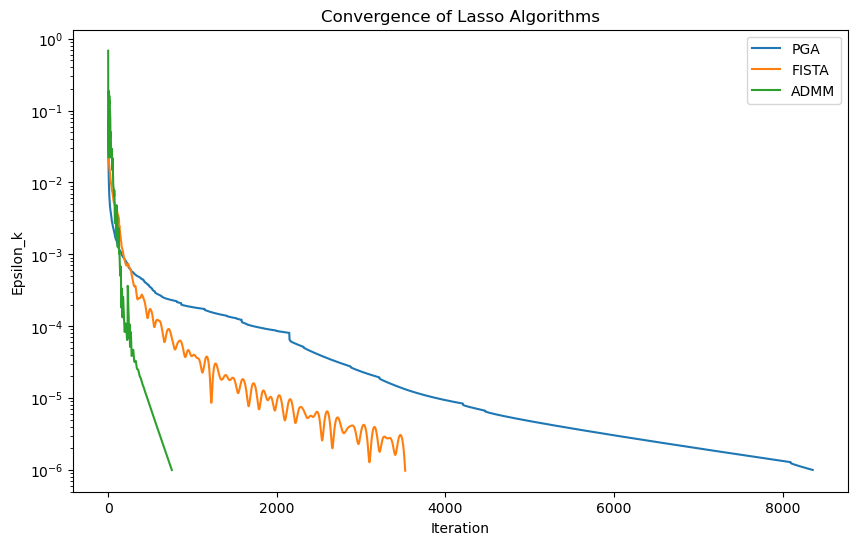

In [10]:
# plot the convergence of the algorithms

coef_pga, eps_k_history_pga = PGALasso(feature_matrix, target_vector, tau=1)
coef_fista, eps_k_history_fista = FISTALasso(feature_matrix, target_vector, tau=1)
coef_admm, eps_k_history_admm = ADMMLasso(feature_matrix, target_vector, tau=1)

# print(coef_pga)
# print(coef_fista)
# print(coef_admm)

plt.figure(figsize=(10, 6))
plt.plot(eps_k_history_pga, label='PGA')
plt.plot(eps_k_history_fista, label='FISTA')
plt.plot(eps_k_history_admm, label='ADMM')
plt.xlabel('Iteration')
plt.ylabel('Epsilon_k')
plt.title('Convergence of Lasso Algorithms')
plt.yscale('log')  # Using a logarithmic scale to better visualize the convergence
plt.legend()
plt.show()

#### Verify your results

Use the following code to check that the $R^2$-score for each method is greater than $0.95$.

In [11]:
# Assuming PGALasso, FISTALasso, and ADMMLasso are implemented as previously described

# Calculate R2 scores
r2_pga = r2_score(target_vector, feature_matrix @ coef_pga)
r2_fista = r2_score(target_vector, feature_matrix @ coef_fista)
r2_admm = r2_score(target_vector, feature_matrix @ coef_admm)

# Print R2 scores
print(f"R2 score for PGALasso: {r2_pga}")
print(f"R2 score for FISTALasso: {r2_fista}")
print(f"R2 score for ADMMLasso: {r2_admm}")

R2 score for PGALasso: 0.9655695532964956
R2 score for FISTALasso: 0.9655850006419548
R2 score for ADMMLasso: 0.965584964096908


### Answer the following question(s):
1. Compare the convergence of the three algorithms, which is fastest in time? Which requires the least iterations?

FISTA is the fastest in time. 
ADMM requires the least iterations.

## Question 6 (8p): Derive the ElasticNet proximal operator

ElasticNet (EN) regularization combines $\ell1$ (Lasso) and $\ell2$ (Ridge) penalty. Assume each is associated with a $\tau_i$ controlling the regularization strength. EN regularization can be defined as:
$$
    f(x) = \tau_1\lVert x \rVert_1 +  \tau_2\lVert x \rVert_2
$$
From this, the proximal operator for EN follows:
$$
    prox_{f(\cdot)}(x) = prox_{\tau_1\lVert\cdot\rVert_1}\left(prox_{\tau_2\lVert\cdot\rVert_2}\right)(x).
$$
**Define the ElasticNet proximal operator** in terms of $\tau$ and $\alpha$, where 
$$
\begin{align*}
\tau &= \tau_1 + \tau_2,\\
\alpha &= \frac{\tau_1}{\tau_1 + \tau_2},
\end{align*}
$$
where $\tau$ controls the total regularization and $\alpha\in[0,1]$  the ratio between the $\ell1$ and $\ell2$ components. In other words, if $\alpha=1$, the proximal is equivalent to Lasso (soft tresholding).

**Hints:** 
 - you should be able to reuse the `soft_thresholding` function made earlier
 - it is recommended to derive the proximal operator analytically on pen&paper before starting to code.
 - the book [Proximal Algorithms](https://web.stanford.edu/~boyd/papers/pdf/prox_algs.pdf) might be a good resource in addition to course material


In [12]:
def proxEN(x, tau, l1_ratio):
    tau_1 = tau * l1_ratio
    tau_2 = tau * (1 - l1_ratio)
    
    x_soft = soft_thresholding(x, l1_ratio * tau)
    x_en = x_soft / (1 + (1 - l1_ratio) * tau)
    
    return x_en
    
    # raise NotImplementedError("You need to implement this function.")

In [13]:
# you can use the following minimal unit-tests to check your function is correct

# check that Lasso proximal is correct (i.e., l1_ratio = 1)
test_input = np.random.randn(4)
tau = 0.2
l1_ratio = 1.0
output = proxEN(test_input, tau, l1_ratio)
print(output)
expected_output = soft_thresholding(test_input, tau)
print(expected_output)
assert np.allclose(output, expected_output), "Lasso proximal incorrect"

# check that ridge proximal is correct (i.e., l1_ratio = 0)
test_input = np.array([0.5, -0.5, 1.5, -1.5])
tau = 0.5
l1_ratio = 0.0
output = proxEN(test_input, tau, l1_ratio)
print(output)
expected_output = test_input/(1 + tau)
print(expected_output)
assert np.allclose(output, expected_output), "Ridge proximal incorrect"

# check that EN proximal is correct (i.e. 0<l1_ratio<1 )
test_input = np.array([0.5, -0.5, 1.5, -1.5])
tau = 0.5
l1_ratio = 0.5
output = proxEN(test_input, tau, l1_ratio)
print(output)
expected_output = np.array([0.2, -0.2, 1, -1])
print(expected_output)
assert np.allclose(output, expected_output), "EN proximal incorrect"


[-0.46877901  1.12273647 -0.00999565  0.        ]
[-0.46877901  1.12273647 -0.00999565  0.        ]
[ 0.33333333 -0.33333333  1.         -1.        ]
[ 0.33333333 -0.33333333  1.         -1.        ]
[ 0.2 -0.2  1.  -1. ]
[ 0.2 -0.2  1.  -1. ]


## Question 7 (25p): Implement ElasticNet with PGA and FISTA
Unilke ADMM, PGA and FISTA are simple to modify for a different objective. Create two new functions `PGAElasticNet` and `FISTAElasticNet`. You should be able to re-use a large part of the Lasso functions. Use the `proxEN` function. 


**Use an l1-ratio of 0.2**

In [14]:
def PGAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6):
    """Linear regression with proximal gradient algorithm and elastic net regularization

    Args:
        feature_matrix (np.array): the feature matrix
        target_vector (np.array): the target vector
        tau (float): the regularization strength
        l1_ratio (float): the ratio between l1 and l2 regularization
        max_iter (int, optional): iteration count. Defaults to MAX_ITER.
        eps_tol (float, optional): tolerance. Defaults to 1e-6.
    """
    n_features = feature_matrix.shape[1]
    xk = np.zeros(n_features)
    alpha = 1 / np.linalg.norm(feature_matrix, ord=2) ** 2
    eps_k_pga = []
    
    for _ in range(max_iter):
        gradient = feature_matrix.T.dot(feature_matrix.dot(xk) - target_vector)
        xk_new = proxEN(xk - alpha * gradient, tau * alpha, l1_ratio)
        
        eps_k = np.linalg.norm(xk_new - xk)
        eps_k_pga.append(eps_k)
        
        if np.linalg.norm(xk_new - xk) <= eps_tol:
            break
        xk = xk_new

    return xk, eps_k_pga
    # raise NotImplementedError("You need to implement this function.")

In [15]:
def FISTAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6):
    """Linear regression with FISTA and elastic net regularization

    Args:
        feature_matrix (np.array): the feature matrix
        target_vector (np.array): the target vector
        tau (float): the regularization strength
        l1_ratio (float): the ratio between l1 and l2 regularization
        max_iter (int, optional): iteration count. Defaults to MAX_ITER.
        eps_tol (float, optional): tolerance. Defaults to 1e-6.
    """
    m, n = feature_matrix.shape
    x = np.zeros(n)
    y = x.copy()
    t = 1
    L = np.linalg.norm(feature_matrix, ord=2) ** 2
    alpha = 1 / L
    eps_k_fista = []

    for _ in range(max_iter):
        x_old = x.copy()
        gradient = feature_matrix.T.dot(feature_matrix.dot(y) - target_vector)
        x = proxEN(y - alpha * gradient, alpha * tau, l1_ratio)
        t_old = t
        t = (1 + np.sqrt(1 + 4 * t ** 2)) / 2
        y = x + ((t_old - 1) / t) * (x - x_old)

        eps_k = np.linalg.norm(x - x_old)
        eps_k_fista.append(eps_k)
        
        if np.linalg.norm(x - x_old) <= eps_tol:
            break

    return x, eps_k_fista
    # raise NotImplementedError("You need to implement this function.")

In [16]:
# run the algorithms and time them, consider using %time, e.g.,
# %time PGAElasticNet(feature_matrix, target_vector, tau=1, l1_ratio=0.9)
start_time = time.time()
coef_pga_en = PGAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6)
pga_en_time = time.time() - start_time

start_time = time.time()
coef_fista_en = FISTAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6)
fista_en_time = time.time() - start_time

pga_en_time, fista_en_time

(1.3249633312225342, 0.4570760726928711)

### Verify your results

Use the given code to compute the R2-scores. They should be noticeably higher (greater than 0.99). Note that while the goodness of fit has increased, this provides no insight whether the generalization of the model improved. Subsequent homework will study generalization and robustness in further detail.

In [17]:
coef_pga_en, eps_k_pga = PGAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6)
coef_fista_en, eps_k_fista = FISTAElasticNet(feature_matrix, target_vector, tau=1.0, l1_ratio=0.2, max_iter=MAX_ITER, eps_tol=1e-6)

# the coef_* refer to the coefficients x returned by the algorithms
r2_pga_en = r2_score(target_vector, feature_matrix @ coef_pga_en)
r2_fista_en = r2_score(target_vector, feature_matrix @ coef_fista_en)
print(f"R2 score for PGAElasticNet: {r2_pga_en}")
print(f"R2 score for FISTAElasticNet: {r2_fista_en}")

R2 score for PGAElasticNet: 0.9957275055624699
R2 score for FISTAElasticNet: 0.9957282850001965


### Answer the following question(s):
1. In a few sentences, explain why ADMM could not be adapted to ElasticNet trivially.


ADMM (Alternating Direction Method of Multipliers) is tailored for separable objectives where the optimization problem can be split into smaller subproblems that can be solved independently. The algorithm leverages the structure of the optimization problem, where it alternates between updating primal variables, dual variables, and then combines them using a Lagrange multiplier update step.

ElasticNet regularization combines the ℓ1 (Lasso) and ℓ2 (Ridge) penalties into a single non-separable objective function. The coupling of ℓ1 and ℓ2 norms in ElasticNet does not lead to a straightforward separation into subproblems that can be addressed independently, which is a key assumption for the ADMM's splitting strategy. While ADMM can be applied to ElasticNet, it requires a more complex reformulation of the problem, such as variable splitting or the introduction of auxiliary variables, to create a structure that ADMM can exploit. This is in contrast to Lasso alone, which readily fits into the ADMM framework due to its separable nature.

### (Optional) Plot convergence figures and/or analyze the coefficients

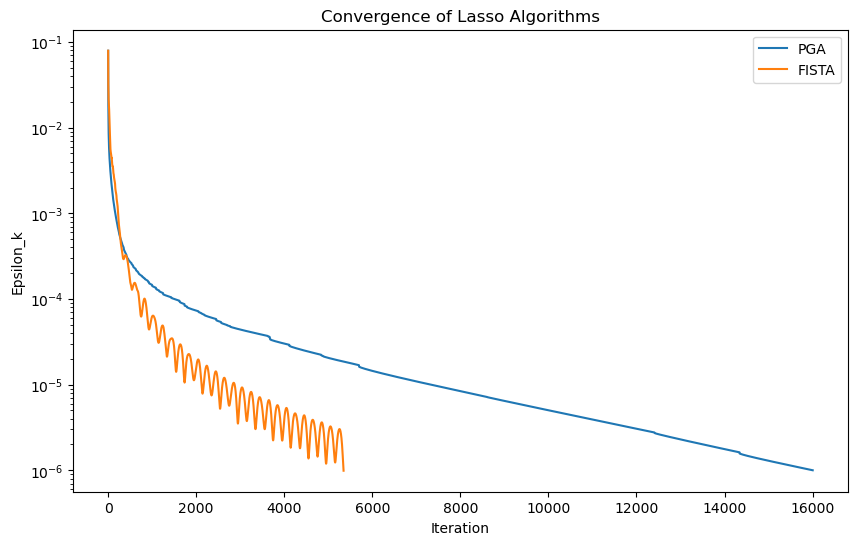

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(eps_k_pga, label='PGA')
plt.plot(eps_k_fista, label='FISTA')
plt.xlabel('Iteration')
plt.ylabel('Epsilon_k')
plt.title('Convergence of Lasso Algorithms')
plt.yscale('log')  # Using a logarithmic scale to better visualize the convergence
plt.legend()
plt.show()